In [1]:
import numpy as np
import pandas as pd

## Reading Features

In [2]:
#PRS = np.load('PRS.npy')
FE = np.load('FE.npy')
labels = np.load('LOS.npy')
#cor = np.load('cor.npy')
#RX = np.load('RX_time.npy')
#RX = np.stack((np.abs(RX), np.angle(RX)), axis = -2)
#print(f'RX shape = {RX.shape}\ncorrelation shape = {cor.shape}\nstatistical feature shape = {FE.shape},\nLOS = {np.unique(labels, return_counts=True)}')
print(f'statistical feature shape = {FE.shape},\nLOS/NLOS labels = {np.unique(labels, return_counts=True)}')

statistical feature shape = (7102, 5, 6),
LOS/NLOS labels = (array([0, 1]), array([6677,  425]))


In [99]:
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import KernelPCA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LearningCurveDisplay, ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Investigating transformation for dimention reduction
Dimention reduction techniques are usually based on eigen value and eigen vector decomposition. BY doing this analysis, we can find that if lower numebr of features are able to explain feature variances or not. If so, a linear or non-linear dimenionality treduction technique such as PCA or LDA can be considered. 

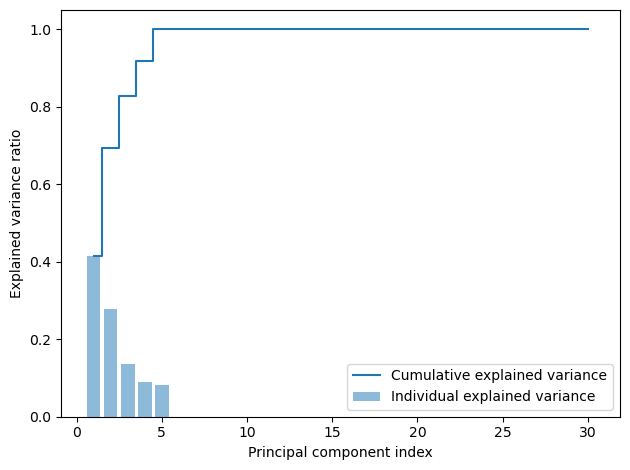

In [4]:
X = FE.reshape(FE.shape[0], -1)
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, X.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, X.shape[1]+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

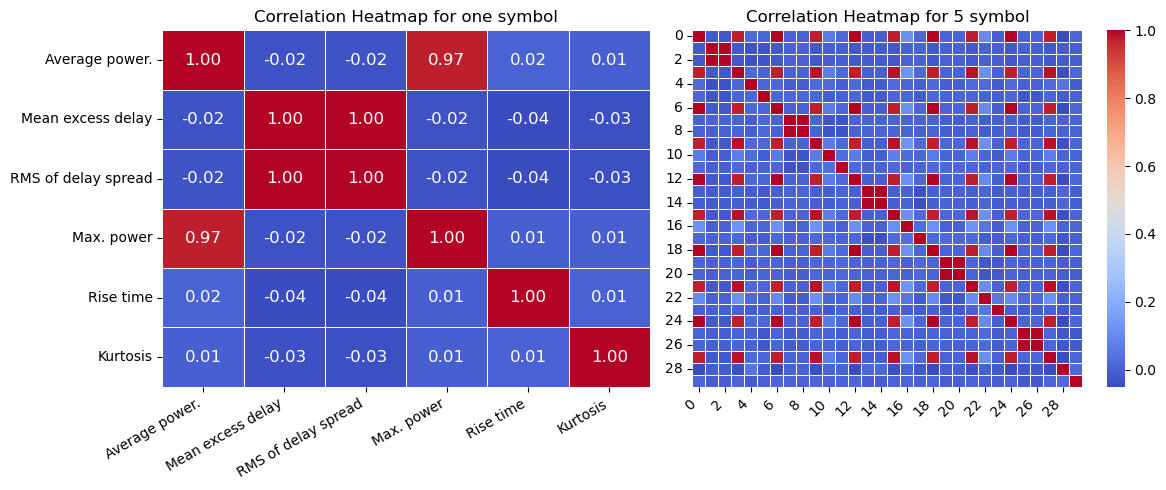

In [5]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X[:,:], rowvar=False)
correlation_labels = ["Average power.", "Mean excess delay", "RMS of delay spread", "Max. power", "Rise time", "Kurtosis"]
# Create a heatmap to visualize the correlation matrix

# Create a mask to display only half of the correlation matrix

# Create a heatmap to visualize the correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(correlation_matrix[:6,:6], annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=False, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[0])
axes[0].set_xticklabels(correlation_labels, rotation=30, horizontalalignment='right')
axes[0].set_yticklabels(correlation_labels, rotation=0, va='center')  # Set custom y-axis labels
axes[0].set_title('Correlation Heatmap for one symbol')

sns.heatmap(correlation_matrix[:,:], annot=False, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=True, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, va='center')  # Set custom y-axis labels if needed
axes[1].set_title('Correlation Heatmap for 5 symbol')

plt.tight_layout()
plt.show()

In [42]:
ind = np.arange(0,X.shape[1], 3)
XX = np.delete(X, ind, axis = 1)
XX.shape

(7102, 20)

In [56]:
# Remove correlated statistical features (Even coulmns)
df = pd.DataFrame(XX)
df.columns
df.iloc[:,:8].describe()

0            1            2             3            4  \
count  7102.000000  7102.000000  7102.000000  7.102000e+03  7102.000000   
mean      0.017058     0.595356     8.331390  1.172447e+03     0.017058   
std       0.000115     0.008002    20.935302  7.295290e-09     0.000114   
min       0.016648     0.567044  -205.454926  1.172447e+03     0.016602   
25%       0.016982     0.590028     0.000000  1.172447e+03     0.016981   
50%       0.017056     0.595227     0.000000  1.172447e+03     0.017058   
75%       0.017136     0.600772     4.730410  1.172447e+03     0.017135   
max       0.017475     0.624779   276.589569  1.172447e+03     0.017538   

                 5            6             7  
count  7102.000000  7102.000000  7.102000e+03  
mean      0.595366    19.890376  1.172447e+03  
std       0.007965    45.837967  7.521404e-09  
min       0.563939  -141.047647  1.172447e+03  
25%       0.589978     0.000000  1.172447e+03  
50%       0.595352     0.000000  1.172447e+03  
75%       0.600721     8.098704  1.172447e+03  
max       0.629282   403.140930  1.172447e+03

## Naive Random serach for best pipeline

In [95]:
X_train, X_test, y_train, y_test = train_test_split(XX, labels, test_size=0.2, random_state=42)

In [116]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
}

transformers = {
    'PCA': PCA(n_components=None),  
    'KernelPCA': KernelPCA(n_components=None),  
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(), 

}

estimators = {
    #classic estimators
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'SGD': SGDClassifier(),
    'NaiveBayes': GaussianNB(), 
    #boosting / ensemble estimators 
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    #Classic MLP, carried on on Scikit learn
    'MLP': MLPClassifier(max_iter = 500), 
}
param_grids = {
        'scaler': list(scalers.values()),
        'transformer': list(transformers.values()),
        'estimator': list(estimators.values())
    }

pipeline = Pipeline([
    ('scaler', None),
    ('transformer', None),
    ('estimator', None)
])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions = param_grids,
    n_iter = 10,
    cv = 10,
    n_jobs = -1,
    verbose = 1,
    random_state = 60,
    scoring = {"AUC": "roc_auc", 'f1': 'f1'},
    refit= 'AUC'
)

random_search.fit(X_train, y_train)

# Get the best parameters for each step
best_scaler = random_search.best_params_['scaler']
best_transformer = random_search.best_params_['transformer']
best_estimator = random_search.best_params_['estimator']

# Now you can use the best parameters to construct the final pipeline
final_pipeline = Pipeline([
    ('scaler', best_scaler),
    ('transformer', best_transformer),
    ('estimator', best_estimator)
])
# Fit the final pipeline to the training data
final_pipeline.fit(X_train, y_train)
final_pipeline

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Pipeline(steps=[('scaler', RobustScaler()), ('transformer', KernelPCA()),
                ('estimator', ExtraTreesClassifier())])

Best Model Accuracy: 0.9380717804363125
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1332
           1       1.00      0.01      0.02        89

    accuracy                           0.94      1421
   macro avg       0.97      0.51      0.50      1421
weighted avg       0.94      0.94      0.91      1421



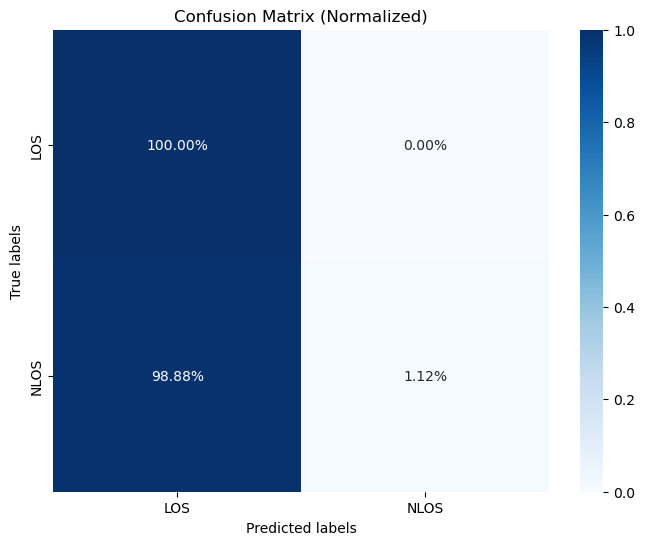

In [117]:
y_pred = final_pipeline.predict(X_test)

# Evaluate the final model on the test data
accuracy = final_pipeline.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)
# Evaluate the final model on the test data
report = classification_report(y_test, y_pred)
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
class_names = ['LOS', 'NLOS']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Normalized)")
plt.show()

In [ ]:
 estimators = {
    #classic estimators
    'LogisticRegression': LogisticRegression(),
        'param': {
            'class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
            'C': [0.01, 0.1, 1.0, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['lbfgs', 'liblinear', 'sag', 'newton-cg'],
            'max_iter': [100, 500, 1000, 10000],
        },
    'SVM': SVC(),
    'SGD': SGDClassifier(),
    'NaiveBayes': GaussianNB(), 
    #boosting / ensemble estimators 
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    #Classic MLP, carried on on Scikit learn
    'MLP': MLPClassifier(), 
}       





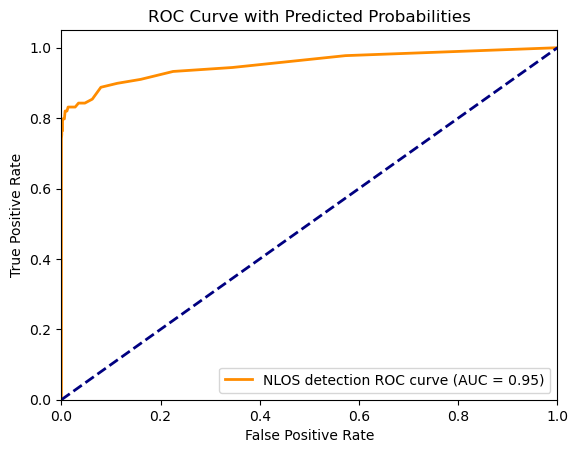

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = final_pipeline.predict_proba(X_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label=1)

# Calculate the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, y_prob[:,1], multi_class='ovr')

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'NLOS detection ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Predicted Probabilities')
plt.legend(loc="lower right")
plt.show()


In [105]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, labels, test_size=0.2, random_state=42)

# Create a pipeline
from sklearn.pipeline import Pipeline

# Define the preprocessing steps, including scaling and normalization
preprocessor = [('scaler', StandardScaler()), ('normalizer', Normalizer())]

# Define the dimensionality reduction steps
dim_reduction = [('pca', PCA()), ('kpca', KernelPCA()), ('lda', LinearDiscriminantAnalysis())]

# Define the classifier
classifier = SVC()

# Combine the preprocessing, dimensionality reduction, and classifier into a single pipeline
pipeline = Pipeline(preprocessor + dim_reduction + [('classifier', classifier)])

# Define the hyperparameters to search
param_grid = {
    'pca__n_components': [1, 2, 3],
    'kpca__kernel': ['linear', 'rbf', 'poly'],
    'kpca__gamma': [0.001, 0.01, 0.1],
    'lda__n_components': [1, 2, 3],
    'classifier__C': [0.1, 1, 10]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = best_model.score(X_test, y_test)
print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy)


KeyboardInterrupt: 

In [101]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, labels, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler, LDA, and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler
    ('lda', LinearDiscriminantAnalysis()),  # LDA
])

# Define hyperparameters and their possible values for the grid search
param_grid = {
    'lda__n_components': [1, 2],  # LDA components
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=10)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the model on the test set
test_score = grid_search.score(X_test, y_test)
print("Test set accuracy:", test_score)

y_pred = grid_search.predict(X_test)

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

confusion


Best hyperparameters: {'lda__n_components': 1}
Best cross-validation score: 0.9408555904849129
Test set accuracy: 0.9373680506685432


/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/

array([[1332,    0],
       [  89,    0]])

array([0, 1])

## Preprocessing Data


In [11]:
X = FE.reshape(FE.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, stratify=labels, random_state=42) #stratify --> the same class distribution in original dataset is guranteed 
print(f'stratified y_tain = {np.unique(y_train, return_counts=True)}\nstratified y_test = {np.unique(y_test, return_counts=True)}')

stratified y_tain = (array([0, 1]), array([4674,  297]))
stratified y_test = (array([0, 1]), array([2003,  128]))


In [12]:
#Transformers
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
#kernel_pca = KernelPCA(kernel='rbf', gamma=15, n_components=None)
#lle_dim_reduction = LocallyLinearEmbedding(n_components=10, random_state=42)

Since there is not a few dominant eignen vectors, the dimentionality reduction techniques are ignored. In practice, adding a Transformer rather than StandardScaler() reduces the final performance

## Finding the best Estimator 



### Grid search to select the best parametrs of each estimators
Ckecking different dimentionality reduction techniques do not provide better performance

In [64]:
scalers = {
    'StandardScaler': {
        'scaler': StandardScaler(),
        'param': {  
            'with_mean': [True, False],
            'with_std': [True, False]
        }
    },
    'MinMaxScaler': {
        'scaler': MinMaxScaler(),
        'param': {  
            'feature_range': [(0, 1), (-1, 1), (0, 2), (-0.5, 0.5)]  # Adjust the feature range as needed
        }
    },
    'RobustScaler': {
        'scaler': RobustScaler(),
        'param': {  
            'quantile_range': [(25.0, 75.0), (10.0, 90.0), (5.0, 95.0)]
        }
    },
}

transformers = {
        'PCA': {
            'transformer': PCA(),
            'param': {  
                'n_components': [None, 1, 2, 3],
        },
    },
        'KernelPCA': {
            'transformer': KernelPCA(),
            'param': {  
                'n_components': [None, 1, 2, 3],
                'kernel': ['linear', 'poly', 'rbf'],
                'gamma': [0.1, 1.0],
        },
    },
        'LinearDiscriminantAnalysis': {
            'transformer': LinearDiscriminantAnalysis(),
            'param': {  
                'n_components': [1],
        },
    }
}

classifiers = {
    'LR': {
        'classifier': LogisticRegression(),
        'param': {
            'class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
            'C': [0.01, 0.1, 1.0, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['lbfgs', 'liblinear', 'sag', 'newton-cg'],
            'max_iter': [100, 500, 1000, 10000],
        }
    },
    'SVM': {
        'classifier': SVC(),
        'param': {
            'class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
            'C': [0.01, 0.1, 1.0, 10],
            'gamma': [0.1, 1, 5, 10],
            'kernel': ['linear', 'rbf', 'poly'],
        }
    },
    'SGD': {
        'classifier': SGDClassifier(),
        'param': {
            'loss': ['log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'squared_epsilon_insensitive'], 
            'alpha': np.random.uniform(1e-6, 1e-1, size = 5), # higher --> stronger L2 regularization
            'max_iter': np.random.randint(200, 10000, 10),
            'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
            'class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        }
    },
    'DT': {
        'classifier': DecisionTreeClassifier(),
        'param': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [5, 10, 15, 20], 
            'min_samples_split': [1, 2, 4, 8], 
            'min_weight_fraction_leaf': [0, 0.1, 0.3, 0.5],
            'max_features': ['sqrt', 'log2'],  
            'class_weight': [None, 'balanced', {0: 1, 1: 1}, {0:1, 1:2}, {0:0.5, 1:2}, {0:0.5, 1:1}],

       }
    }, 
    'NB': {
        'classifier': GaussianNB(),
        'param': {
        'var_smoothing': [1e-8, 1e-7, 1e-6], 
        }
    },
    'GB': {
        'classifier': GradientBoostingClassifier(),
        'param': {
            'n_estimators': [10, 50, 100], 
            'learning_rate': [0.1, 0.05, 0.01],
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        },
    },
    'RF': {
        'classifier': RandomForestClassifier(),
        'param': {
            'class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
            'n_estimators': [10, 50, 100], 
            'max_depth': [5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
            'min_samples_leaf': [1, 2, 4, 8],            # Minimum samples required at each leaf node
            'max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
            'criterion': ['gini', 'entropy'],
        }
    },
    'ET': {
        'classifier': ExtraTreesClassifier(),
        'param': {
            'n_estimators': [10, 50, 100],
            'criterion': ['gini', 'entropy', 'logloss'],
            'max_depth': [10, 15, 20],
            'min_samples_leaf': [1, 2, 10],
            'max_features': ['sqrt', 'log2', 'None'],
            'class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        },

    },
    'ADA': {
        'classifier': AdaBoostClassifier(),
        'param': {
            'n_estimators': [10, 50, 100],
            'learning_rate': np.random.uniform(1, 2, size = 5),
        },

    },
    'MLP': {
    'classifier': MLPClassifier(), 
    'param': {
        'hidden_layer_sizes': [(50, 50), (100, 100, 100), (30, 20, 10)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'alpha': np.logspace(-1, 1, 5),  # L2 regularization strength
        'learning_rate': ['constant', 'adaptive'],
        'learning_rate_init': np.random.uniform(1e-6, 1e-1, size = 5),
        'max_iter': np.random.randint(200, 10000, 10),
        },
    }
}


In [72]:
scaler_list = [scalers[scaler_type]['scaler'] for scaler_type in scalers]
transformer_list = [transformers[transformer_type]['transformer'] for transformer_type in transformers]
classifier_list = [classifiers[classiffier_type]['classifier'] for classiffier_type in classifiers]
print(scaler_list)
print(transformer_list)
print(classifier_list)
scaler_param = [scalers[scaler_type]['param'] for scaler_type in scalers]
transformer_param = [transformers[transformer_type]['param'] for transformer_type in transformers]
classifier_param = [classifiers[classiffier_type]['param'] for classiffier_type in classifiers]
print(scaler_param + transformer_param + classifier_param)

[StandardScaler(), MinMaxScaler(), RobustScaler()]
[PCA(), KernelPCA(), LinearDiscriminantAnalysis()]
[LogisticRegression(), SVC(), SGDClassifier(), DecisionTreeClassifier(), GaussianNB(), GradientBoostingClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), AdaBoostClassifier(), MLPClassifier()]
[{'with_mean': [True, False], 'with_std': [True, False]}, {'feature_range': [(0, 1), (-1, 1), (0, 2), (-0.5, 0.5)]}, {'quantile_range': [(25.0, 75.0), (10.0, 90.0), (5.0, 95.0)]}, {'n_components': [None, 1, 2, 3]}, {'n_components': [None, 1, 2, 3], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': [0.1, 1.0]}, {'n_components': [1]}, {'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}], 'C': [0.01, 0.1, 1.0, 10], 'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear', 'sag', 'newton-cg'], 'max_iter': [100, 500, 1000, 10000]}, {'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}], 'C': [0.01, 0.1, 1.0, 10], 'gamma': [0.1, 1, 5, 10], 'kernel': ['linear', 'rbf', 'p

In [75]:
param_dist = {
    'estimator': classifier_list,
    'scaler': scaler_list,
    'transformer': transformer_list
}

In [84]:
pipeline = Pipeline([
    ('scaler', None),
    ('transformer', None),
    ('estimator', None)
])
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions = param_dist,
    n_iter = 100,
    cv = 10,
    n_jobs = -1,
    verbose = 1,
    random_state = 117,
    scoring='f1',  # You can change the scoring metric
    refit= False
    )
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', None),
                                             ('transformer', None),
                                             ('estimator', None)]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator': [LogisticRegression(),
                                                      SVC(), SGDClassifier(),
                                                      DecisionTreeClassifier(),
                                                      GaussianNB(),
                                                      GradientBoostingClassifier(),
                                                      RandomForestClassifier(),
                                                      ExtraTreesClassifier(),
                                                      AdaBoostClassifier(),
                                                      MLPClassifier()],
                                        'scaler': [StandardScaler(),
                                                   MinMaxScaler(),
                                                   RobustScaler()],
                                        'transformer': [PCA(), KernelPCA(),
                                                        LinearDiscriminantAnalysis()]},
                   random_state=117, refit=False, scoring='f1', verbose=1)

Best Model Accuracy: 0.8669950738916257
Best Model F1 Score: 0.875579938412469


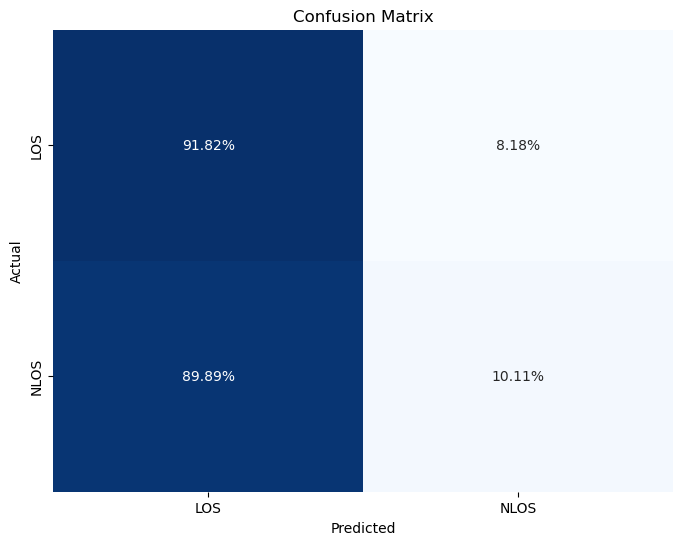

Accuracy: 86.70%
Precision: 88.46%
Recall: 86.70%
F1 Score: 87.56%
              precision    recall  f1-score   support

         LOS       0.94      0.92      0.93      1332
        NLOS       0.08      0.10      0.09        89

    accuracy                           0.87      1421
   macro avg       0.51      0.51      0.51      1421
weighted avg       0.88      0.87      0.88      1421



Pipeline(steps=[('scaler', StandardScaler()), ('transformer', PCA()),
                ('estimator', DecisionTreeClassifier())])

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
# Get the best parameters for each step
best_scaler = random_search.best_params_['scaler']
best_transformer = random_search.best_params_['transformer']
best_estimator = random_search.best_params_['estimator']

# Now you can use the best parameters to construct the final pipeline
final_pipeline = Pipeline([
    ('scaler', best_scaler),
    ('transformer', best_transformer),
    ('estimator', best_estimator)
])
# Fit the final pipeline to the training data
final_pipeline.fit(X_train, y_train)

# Evaluate the final model on the test data
accuracy = final_pipeline.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)


y_pred = final_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Best Model F1 Score:", f1)

class_names = ['LOS', 'NLOS']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Create class names

# Plot the confusion matrix with percentages and class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names)
plt.show()

# Print accuracy, precision, recall, and F1 score
print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1 Score: {f1:.2%}')

# Print classification report
print(classification_report(y_test, y_pred, target_names=class_names))
final_pipeline


In [185]:
for classifier_name, config in transformers.items():
    print(classifier_name)
    print(config)
    """    scaler = config['scaler']
        scaler_param = config['param']
        
        transformer = config['transformer']
        transformer_param_param = config['param']
        
        classifier = config['classifier']
        classifir_param = config['param']
        print(scaler,transformer,classifier)"""

    """random_search = RandomizedSearchCV(
        estimator=classifier,
        param_distributions = param,
        n_iter = 10,
        cv = 10,
        n_jobs = -1,
        verbose = 1,
        random_state = 1712,
        scoring='f1',  # You can change the scoring metric
        refit= True
    )

    random_search.fit(X_train, y_train)
    classifier.set_params(**random_search.best_params_)"""


PCA
{'transformer': PCA(), 'param': {'n_components': [None, 1, 2, 3]}}
KernelPCA
{'transformer': KernelPCA(), 'param': {'n_components': [None, 1, 2, 3], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': [0.1, 1.0]}}
LinearDiscriminantAnalysis
{'transformer': LinearDiscriminantAnalysis(), 'param': {'n_components': [1]}}


In [162]:
param_grid

{'scaler': [{'scaler': StandardScaler(),
   'param': {'with_mean': [True, False], 'with_std': [True, False]}},
  {'scaler': MinMaxScaler(),
   'param': {'feature_range': [(0, 1), (-1, 1), (0, 2), (-0.5, 0.5)]}},
  {'scaler': RobustScaler(),
   'param': {'quantile_range': [(25.0, 75.0), (10.0, 90.0), (5.0, 95.0)]}}],
 'transformer': [{'transformer': PCA(),
   'param': {'n_components': [None, 1, 2, 3]}},
  {'transformer': KernelPCA(),
   'param': {'n_components': [None, 1, 2, 3],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [0.1, 1.0]}},
  {'transformer': LinearDiscriminantAnalysis(),
   'param': {'n_components': [1]}}],
 'estimator': [LogisticRegression(),
  SVC(),
  SGDClassifier(),
  GaussianNB(),
  DecisionTreeClassifier(),
  RandomForestClassifier(),
  GradientBoostingClassifier(),
  ExtraTreesClassifier(),
  AdaBoostClassifier(),
  MLPClassifier()]}

In [160]:
for scaler_name, config in scalers.items():
    scaler = config['scaler']
    param = config['param']
    pipeline = make_pipeline(scaler)

StandardScaler()
{'with_mean': [True, False], 'with_std': [True, False]}
MinMaxScaler()
{'feature_range': [(0, 1), (-1, 1), (0, 2), (-0.5, 0.5)]}
RobustScaler()
{'quantile_range': [(25.0, 75.0), (10.0, 90.0), (5.0, 95.0)]}


In [148]:
X = MinMaxScaler().fit_transform(X_train)
for scaler_name, config in transformers.items():
    scaler = config['transformer']
    param = config['param']


    random_search = RandomizedSearchCV(
        estimator=scaler,
        param_distributions = param,
        cv = 10,
        n_jobs = -1,
        verbose = 1,
        scoring = 'explained_variance',
        refit= False
    )

    random_search.fit(X, y_train)
    transformers[scaler_name] = random_search.best_params_


/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

Fitting 10 folds for each of 1 candidates, totalling 10 fits


{'StandardScaler': {'scaler': StandardScaler(),
  'param': {'with_mean': [True, False], 'with_std': [True, False]}},
 'MinMaxScaler': {'scaler': MinMaxScaler(),
  'param': {'feature_range': [(0, 1), (-1, 1), (0, 2), (-0.5, 0.5)]}},
 'RobustScaler': {'scaler': RobustScaler(),
  'param': {'quantile_range': [(25.0, 75.0), (10.0, 90.0), (5.0, 95.0)]}},
 'PCA': {'n_components': None},
 'KernelPCA': {'n_components': None, 'kernel': 'linear', 'gamma': 0.1},
 'LinearDiscriminantAnalysis': {'n_components': 1}}

In [ ]:
for transformer_name, config in transformers.items():
    transformer = config['classifier']
    param = config['param']

    random_search = RandomizedSearchCV(
        estimator=scaler,
        param_distributions = param,
        n_iter = 10,
        cv = 10,
        n_jobs = -1,
        verbose = 1,
        random_state = 1712,
        scoring='f1',  # You can change the scoring metric
        refit= False
    )

    random_search.fit(X_train, y_train)
    classifier.set_params(**random_search.best_params_)

for classifier_name, config in classifiers.items():
    classifier = config['classifier']
    param = config['param']


    random_search = RandomizedSearchCV(
        estimator=classifier,
        param_distributions = param,
        n_iter = 10,
        cv = 10,
        n_jobs = -1,
        verbose = 1,
        random_state = 1712,
        scoring='f1',  # You can change the scoring metric
        refit= True
    )

    random_search.fit(X_train, y_train)
    classifier.set_params(**random_search.best_params_)


# Get the best parameters for each step
    #best_scaler = random_search.best_params_['scaler']
    #best_transformer = random_search.best_params_['transformer']
    #best_estimator = random_search.best_params_['estimator']
    

In [77]:
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', KernelPCA()),
                ('LR', LogisticRegression())])

In [20]:
for estimator_name, estimator in classifiers.items():
    print(f"Parameters for {estimator_name}:")
    classifier = estimator['classifier']
    params = classifier.get_params()
    for param, value in params.items():
        print(f"  {param}: {value}")
    print("\n")

Parameters for LR:
  C: 10
  class_weight: None
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 10000
  multi_class: auto
  n_jobs: None
  penalty: l2
  random_state: None
  solver: sag
  tol: 0.0001
  verbose: 0
  warm_start: False


Parameters for SVM:
  C: 0.1
  break_ties: False
  cache_size: 200
  class_weight: {0: 0.5, 1: 1}
  coef0: 0.0
  decision_function_shape: ovr
  degree: 3
  gamma: 0.1
  kernel: poly
  max_iter: -1
  probability: False
  random_state: None
  shrinking: True
  tol: 0.001
  verbose: False


Parameters for DT:
  ccp_alpha: 0.0
  class_weight: balanced
  criterion: entropy
  max_depth: 15
  max_features: sqrt
  max_leaf_nodes: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 2
  min_weight_fraction_leaf: 0
  random_state: None
  splitter: random


Parameters for RF:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: {0: 1, 1: 2}
  criterion: entropy
  max_depth: 20
  max_features: log2
  max_l

In [16]:
for classifier_name, config in classifiers.items():
    classifier = config['classifier']
    print(classifier)

LogisticRegression(class_weight={0: 0.5, 1: 1}, max_iter=500,
                   solver='liblinear')
SVC(C=10, class_weight={0: 1, 1: 2}, gamma=0.1)
SGDClassifier(alpha=0.012936930750232683, class_weight='balanced',
              loss='log_loss', max_iter=2657)
DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=5, max_features='log2', min_samples_split=4,
                       min_weight_fraction_leaf=0, splitter='random')
GaussianNB(var_smoothing=1e-08)
GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=2,
                           min_samples_split=5, n_estimators=50)
RandomForestClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=5, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=10)
ExtraTreesClassifier(class_weight={0: 0.5, 1: 1}, max_depth=10,
                     max_features='log2', min_samples_leaf=2)
AdaBoostClassifier(learning_rate=1.26153

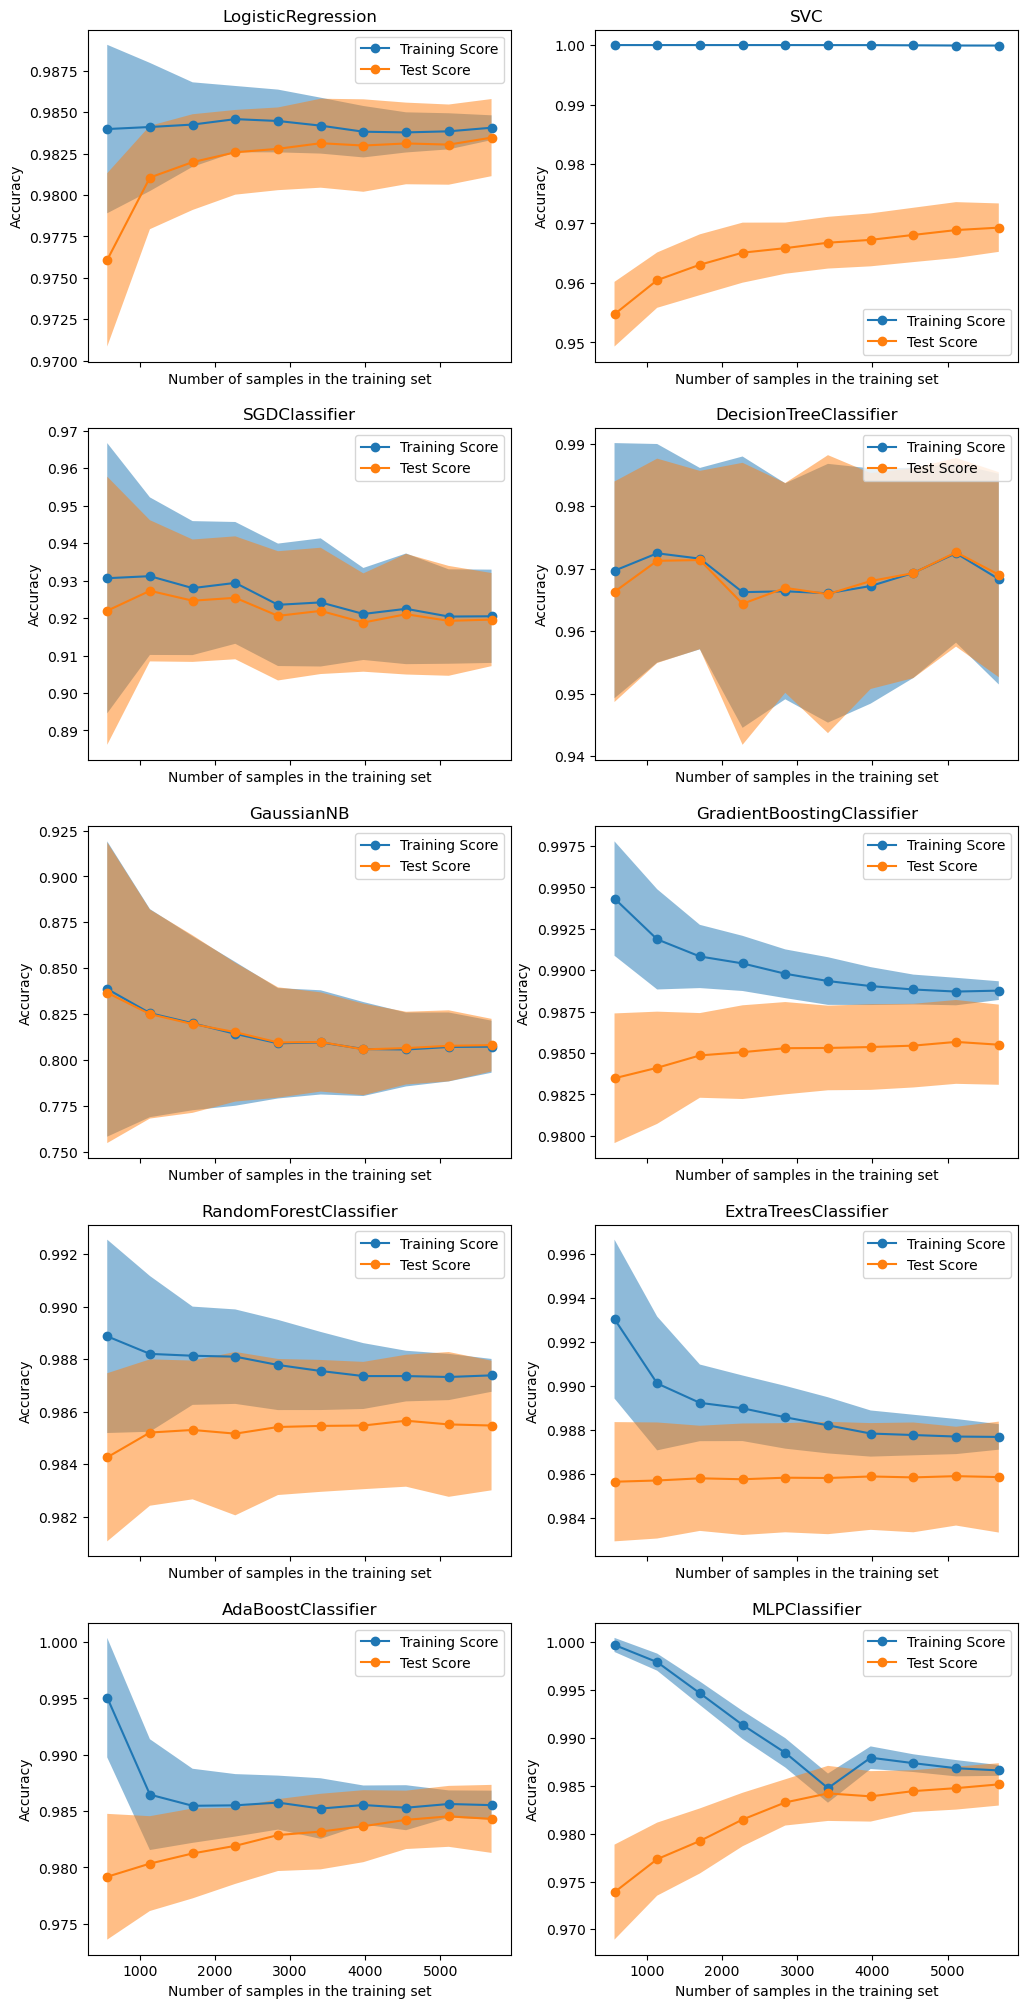

In [15]:
n_splits = 50
common_params = {
    "X": X_selected,
    "y": labels,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits= n_splits, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}


fig, ax = plt.subplots(nrows= int(0.5*len(classifiers)), ncols=2, figsize=(12, 25), sharex = True)
ax_ind = 0
for _, config in classifiers.items():
    row, col = divmod(ax_ind, 2)
    classifier = config['classifier']
    LearningCurveDisplay.from_estimator(classifier, **common_params, ax=ax[row, col])
    handles, label = ax[row,col].get_legend_handles_labels()
    ax[row,col].legend(handles[:2], ["Training Score", "Test Score"])
    ax[row,col].set_title(f"{classifier.__class__.__name__}")
    ax_ind += 1

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter grid for random search
param_dist = {
    'hidden_layer_sizes': [(50, 50), (100, 100, 100), (30, 20, 10)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(1e-5, 1e-2),  # L2 regularization strength
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(1e-4, 1e-2),
    'max_iter': randint(100, 1000),
}

# Create an MLP classifier
mlp = MLPClassifier()

# Perform random search
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=10, n_jobs=-1, verbose=1)

# Fit the model with random search
random_search.fit(X_std, labels)  # Replace X and y with your data

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model
best_mlp = random_search.best_estimator_

# You can now use the best model for predictions
y_pred = best_mlp.predict(X_test)  # Replace X_test with your test data


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (394) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (394) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (510) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (510) reached and the optimization hasn't converged yet.
  warnings.warn(
/hom

Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.004310739613370281, 'hidden_layer_sizes': (30, 20, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.0016382046943070228, 'max_iter': 394, 'solver': 'adam'}


/tmp/ipykernel_1187661/2728262485.py:48: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stoch

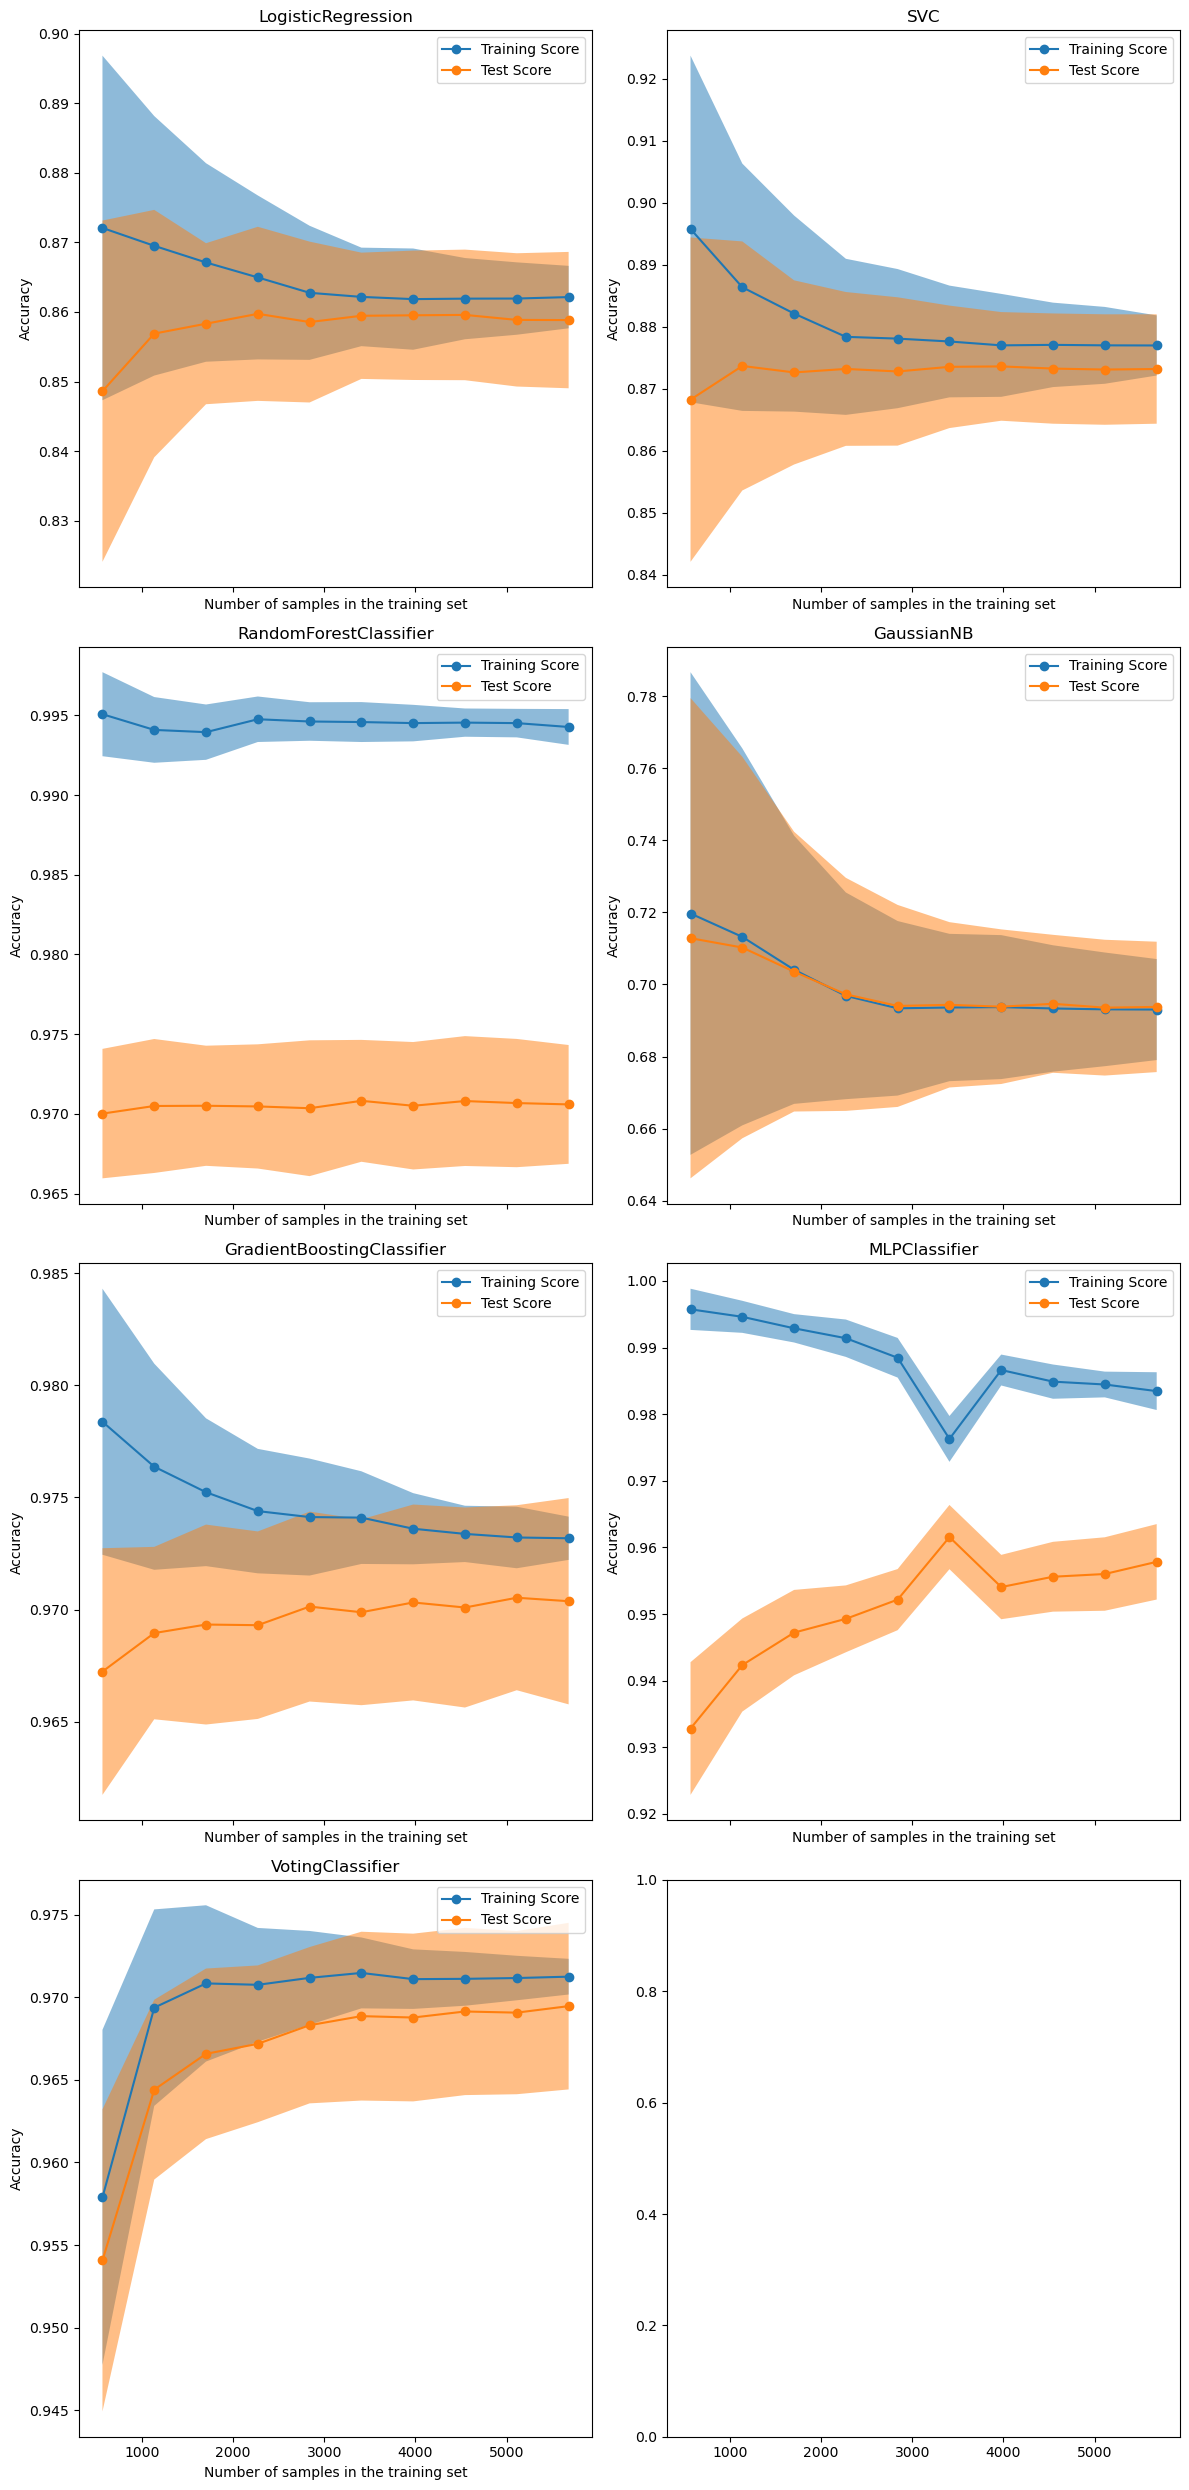

In [16]:
#data standardization
#X_train_std = scaler.fit_transform(X_train)
#X_test_std = scaler.transform(X_test)
X_std = scaler.fit_transform(X)
# Create classifiers
LR = LogisticRegression(class_weight= 'balanced', solver = 'liblinear', penalty = 'l2', max_iter = 200, C = 1.0, random_state=1)
SVM = SVC(kernel='linear', gamma = 0.1, probability = True, class_weight = 'balanced', C = 1.0, random_state=1) #C is inversely proportional to regularization strenght
RF = RandomForestClassifier(n_estimators = 10, criterion='entropy', max_depth = 15, random_state=1)
NB = GaussianNB(var_smoothing = 1e-7)
GB = GradientBoostingClassifier(loss='log_loss', n_estimators=100, learning_rate=0.01)
MLP = MLPClassifier(hidden_layer_sizes = (30, 20, 10), 
                    activation='logistic', 
                    solver = 'adam', 
                    alpha = 0.004310739613370281, 
                    learning_rate = 'constant', 
                    learning_rate_init = 0.0016382046943070228,
                    max_iter=400, 
                    nesterovs_momentum = True,
                    random_state=42)
#AdaB = AdaBoostClassifier(estimator=svm, n_estimators=50, algorithm='SAMME.R', learning_rate=1, random_state=42)

#Majority voting
MV = VotingClassifier(estimators = [ ('svm', SVM), ('GB', GB), ], voting = 'soft')

classifiers = [LR, SVM, RF, NB, GB, MLP, MV]

n_splits = 50
common_params = {
    "X": X_std,
    "y": labels,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits= n_splits, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}


fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 25), sharex = True)
for ax_idx, estimator in enumerate(classifiers):
    row, col = divmod(ax_idx, 2)
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[row, col])
    handles, label = ax[row,col].get_legend_handles_labels()
    ax[row,col].legend(handles[:2], ["Training Score", "Test Score"])
    ax[row,col].set_title(f"{estimator.__class__.__name__}")
    fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


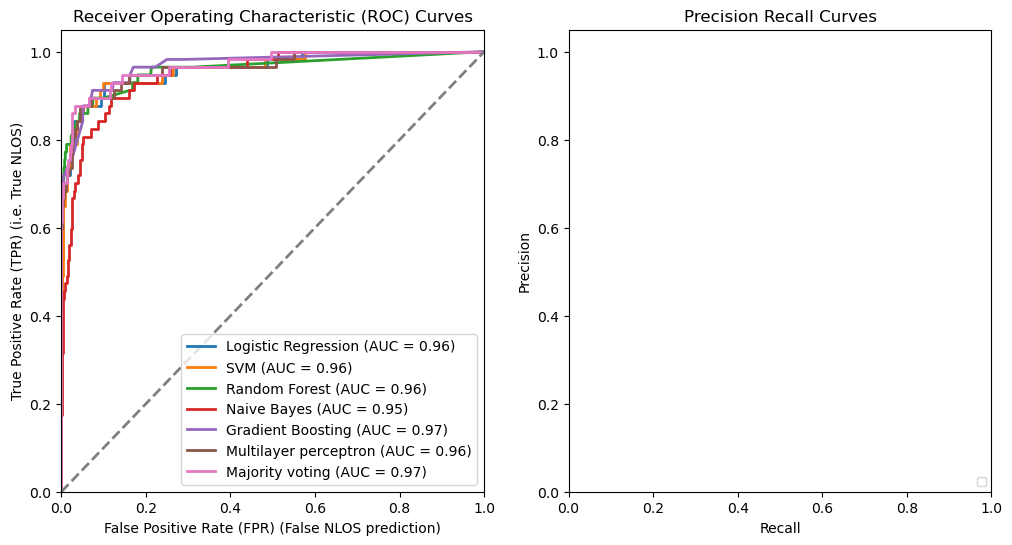

In [65]:
#data standardization
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create classifiers
LR = LogisticRegression(class_weight= 'balanced', solver = 'liblinear', penalty = 'l2', max_iter = 100, C = 1.0, random_state=1)
SVM = SVC(kernel='linear', gamma = 0.1, probability = True, class_weight = 'balanced', C = 1.0, random_state=1) #C is inversely proportional to regularization strenght
RF = RandomForestClassifier(n_estimators = 10, criterion='entropy', max_depth = 15, random_state=1)
NB = GaussianNB(var_smoothing = 1e-7)
GB = GradientBoostingClassifier(loss='log_loss', n_estimators=100, learning_rate=0.01)
MLP = MLPClassifier(hidden_layer_sizes=(50, 50), activation='logistic', solver='adam', alpha = 0.1, learning_rate='constant', max_iter=200, random_state=42)
#AdaB = AdaBoostClassifier(estimator=svm, n_estimators=50, algorithm='SAMME.R', learning_rate=1, random_state=42)

#Majority voting
MV = VotingClassifier(estimators = [ ('lr', LR), ('svm', SVM), ('rf', RF), ('GB', GB), ('MLP', MLP)], voting = 'soft')


classifiers = {
    'Logistic Regression': LR,
    'SVM': SVM,
    'Random Forest': RF,
    'Naive Bayes': NB,
    'Gradient Boosting': GB,
    #'Ada Boosting': AdaB,
    'Multilayer perceptron': MLP,
    'Majority voting': MV
}

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# Plot ROC curves for each classifier

#optimal_thresholds = {}
#fig, axes = plt.subplots(1, 2, figsize=(12, 6))
mean_fpr = np.linspace(0, 1, 100)

output = {}
for name, classifier in classifiers.items():
    
    tpr_list = []
    auc_list = []
    precision_list = []
    average_precision_list = []
    treshold_list = []
    
    for train_index, test_index in skf.split(X, labels):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
    #standardized selected fold
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        
    # Train the classifier on the training data fold 
        classifier.fit(X_train_std, y_train)
    
    # Predict probabilities for the positive class
        y_scores = classifier.predict_proba(X_test_std)[:, 1]
    
    # Compute ROC curve and ROC area (AUC)
        fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        
        tpr_list.append(np.interp(mean_fpr, fpr, tpr))
        auc_list.append(auc(fpr, tpr))
        tpr_list[-1][0] = 0.0  # Start with 0
        average_precision_list.append(average_precision_score(y_test, y_scores))
        
        op_threshold_index = np.argmax(tpr - fpr)
        op_threshold = thresholds[op_threshold_index]
        treshold_list.append(op_threshold)
    
    output['name'].append({'tpr':tpr_list}, {'auc': auc_list}, {'threshold': treshold_list},  )
 """   # Plot ROC curve
    axes[0].plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    #axes[1].plot(precision, recall, lw=2, label=f'{name}')

# Plot the random guess line (diagonal)
axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate (FPR) (False NLOS prediction)')
axes[0].set_ylabel('True Positive Rate (TPR) (i.e. True NLOS)')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curves')
axes[0].legend(loc='lower right')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision Recall Curves')
axes[1].legend(loc='lower right', fontsize = 8)"""


In [66]:
optimal_thresholds['Random Forest']

[{'fpr': array([0.        , 0.        , 0.        , 0.        , 0.00152905,
         0.00917431, 0.00917431, 0.01681957, 0.01681957, 0.02293578,
         0.02293578, 0.02446483, 0.02752294, 0.03058104, 0.03058104,
         0.05351682, 0.05351682, 0.06116208, 0.06269113, 0.06269113,
         0.0733945 , 0.0733945 , 0.08409786, 0.08715596, 0.08868502,
         0.09327217, 0.10550459, 0.10550459, 0.10703364, 0.15137615,
         0.15443425, 0.15749235, 0.17431193, 0.17889908, 0.18807339,
         0.18807339, 0.1911315 , 0.1911315 , 0.19571865, 0.20183486,
         0.20642202, 0.20948012, 0.21865443, 0.22782875, 0.2293578 ,
         0.23547401, 0.23853211, 0.24006116, 0.24311927, 0.24770642,
         0.26452599, 1.        ]),
  'tpr': array([0.        , 0.59649123, 0.63157895, 0.68421053, 0.70175439,
         0.70175439, 0.73684211, 0.73684211, 0.77192982, 0.77192982,
         0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.80701754,
         0.80701754, 0.8245614 , 0.8245614 , 0.8245614

## Find the optimum Threshold based on 10-fold cross validation

In [15]:
#Find the optimum Threshold based on 10-fold cross validation
# Number of splits for k-fold cross-validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

optimal_k_fold_threshold = []
fold_f1_scores = []
fold_accuracy_score = []
for train_index, test_index in skf.split(X, labels):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
        
    #standardized selected fold
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
        
    # Fit the model on the training data
    MV.fit(X_train_std, y_train)
        
    # Predict probabilities for the test set
    y_prob = MV.predict_proba(X_test_std)[:, 1]
        
    # Find the optimal threshold (e.g., maximize TPR while controlling FPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    optimal_k_fold_threshold.append(optimal_threshold)
    
    # Apply the threshold
    y_pred = (y_prob >= optimal_threshold).astype(int)
        
    # Calculate F1 score for this fold
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    fold_f1_scores.append(f1)
    fold_accuracy_score.append(acc)

In [21]:
fold_f1_scores

[0.6814814814814815,
 0.5125628140703518,
 0.5684210526315789,
 0.6322580645161291,
 0.748201438848921,
 0.6573426573426573,
 0.6021505376344086,
 0.4369747899159664,
 0.5660377358490566,
 0.7812499999999999]

In [133]:
#estimators
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50,random_state=1)
clf3 = GaussianNB()
svm_classifier = SVC(kernel='rbf', C=1, probability=True)
clf4 = AdaBoostClassifier(estimator=svm_classifier, n_estimators=50, algorithm='SAMME.R', learning_rate=2, random_state=42)

#Majority voting
voting_classifier = VotingClassifier(estimators = [ ('ada', clf4), ('rf', clf2)], voting = 'soft')

#Transformers
scaler = StandardScaler()
kernel_pca = KernelPCA(kernel='rbf', gamma=15, n_components=None)
lle_dim_reduction = LocallyLinearEmbedding(n_components=10, random_state=42)

pipeline = Pipeline([
    ('scaler', scaler), 
    #('kernel_pca', kernel_pca),
    #('lle', lle_dim_reduction),
    ('voting', voting_classifier)
])

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


In [88]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[1959    2]
 [  76   94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1961
           1       0.98      0.55      0.71       170

    accuracy                           0.96      2131
   macro avg       0.97      0.78      0.84      2131
weighted avg       0.96      0.96      0.96      2131



In [36]:
# Plot decision boundaries (for visualization)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = kernel_pca.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=labels, marker='o', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries')
plt.show()

ValueError: cannot reshape array of size 85626 into shape (201,213)

In [64]:
data = RX.reshape(FE.shape[0], -1)
dataset = tf.data.Dataset.from_tensor_slices((data, labels))
# Define the split ratio (e.g., 80% train, 20% test)
train_ratio = 0.7
num_samples = len(RX)
num_train_samples = int(train_ratio * num_samples)

# Shuffle the dataset (optional)
#dataset = dataset.shuffle(buffer_size=num_samples)

# Split the dataset into train and test datasets
train_ds = dataset.take(num_train_samples)
test_ds = dataset.skip(num_train_samples)

batch_size = 128
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

print("Number of train samples:", num_train_samples)
print("Number of test samples:", num_samples - num_train_samples)

Number of train samples: 4963
Number of test samples: 2127


In [65]:
model_1 = tfdf.keras.RandomForestModel(verbose=2)
model_1.fit(train_ds)

Use 12 thread(s) for training
Use /tmp/tmp6m9sye87 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 20480), dtype=float64)
Label: Tensor("data_1:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>), 'data:0.5': SemanticTensor(semantic=<Semantic.NUMERICA

[INFO 23-10-09 12:10:00.2937 CEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-10-09 12:10:00.2937 CEST kernel.cc:774] Collect training examples
[INFO 23-10-09 12:10:00.2937 CEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-10-09 12:10:00.3528 CEST kernel.cc:393] Number of batches: 39
[INFO 23-10-09 12:10:00.3528 CEST kernel.cc:394] Number of examples: 4963
[INFO 23-10-09 12:10:00.9886 CEST kernel.cc:794] Training dataset:
Number of records: 4963
Number of columns: 20481

Number of columns by type:
	NUMERICAL: 20480 (99.9951%)
	CATEGORICAL: 1 (0.00488257%)

Columns:

NUMERICAL: 20480 (99.9951%)
	1: "data:0.0" NUMERICAL mean:1.42878

Model trained in 0:01:03.895566
Compiling model...
Model compiled.


In [57]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

17/17 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.9121

loss: 0.0000
accuracy: 0.9121


In [58]:
# The input features
# The feature importances
model_1.make_inspector().variable_importances()

{'NUM_NODES': [("data:0.2" (1; #13), 595.0),
  ("data:0.1" (1; #2), 554.0),
  ("data:0.27" (1; #21), 549.0),
  ("data:0.21" (1; #15), 545.0),
  ("data:0.9" (1; #30), 541.0),
  ("data:0.13" (1; #6), 540.0),
  ("data:0.15" (1; #8), 527.0),
  ("data:0.26" (1; #20), 519.0),
  ("data:0.14" (1; #7), 508.0),
  ("data:0.7" (1; #28), 475.0),
  ("data:0.8" (1; #29), 459.0),
  ("data:0.3" (1; #24), 448.0),
  ("data:0.16" (1; #9), 443.0),
  ("data:0.25" (1; #19), 436.0),
  ("data:0.20" (1; #14), 424.0),
  ("data:0.12" (1; #5), 399.0),
  ("data:0.6" (1; #27), 394.0),
  ("data:0.24" (1; #18), 393.0),
  ("data:0.19" (1; #12), 375.0),
  ("data:0.0" (1; #1), 372.0),
  ("data:0.18" (1; #11), 347.0),
  ("data:0.10" (1; #3), 184.0),
  ("data:0.22" (1; #16), 174.0),
  ("data:0.4" (1; #25), 174.0),
  ("data:0.28" (1; #22), 137.0)],
 'SUM_SCORE': [("data:0.24" (1; #18), 43316.598988640006),
  ("data:0.12" (1; #5), 34310.22864237067),
  ("data:0.0" (1; #1), 31340.313022694434),
  ("data:0.18" (1; #11), 30629.

In [5]:


# Load and preprocess your data
# Assuming your data is already loaded into a NumPy array called "data" of shape (1702, 5, 2, 2048)
# You may need to adapt this part to your specific data loading and preprocessing logic

# Reshape the data to a tabular format (flatten the dimensions)
data = data.reshape(1702, -1)

# Assuming you have labels for your data (replace with your actual labels)
labels = np.random.randint(0, 2, size=(1702,))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create a DataFrame for TF-DF
train_data = pd.DataFrame(X_train)
train_data['label'] = y_train

test_data = pd.DataFrame(X_test)
test_data['label'] = y_test

# Define the TF-DF configuration
task = tfdf.keras.premade.Task(
    label="label",
    # Specify if it's a classification or regression task
    # For classification: tfdf.keras.premade.Task.LABEL_CLASSIFICATION
    # For regression: tfdf.keras.premade.Task.LABEL_REGRESSION
)

# Create the RandomForestModel (GBT model)
model = tfdf.keras.GradientBoostedTreesModel(task=task)

# Train the model
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, task=task)
model.fit(train_data)

# Make predictions
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task=task)
predictions = model.predict(test_data)

# Convert predictions to labels
predicted_labels = predictions['predicted_label'].numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")


NameError: name 'data' is not defined